In [36]:
# importing packages
using Plots

# numerical values
h = 100.                        # W/m²K
D = 0.005                       # m
δx = 0.001                      # RK4 step
Tₚ = 373.15                      # K
Tₑₙᵥ = 298.15                    # K
x_max = 0.4                      # m maximun length of solution
N = Int64(x_max / δx);           # number of RK4 iterations                      

In [37]:
# solve ODE system for arbitrary γ₀
function solve_ODE(γ₀, k)

    m = ((4*h)/(k*D))^0.5
    
    γ = Vector{Float64}()
    θ = Vector{Float64}()

    push!(θ, (Tₚ - Tₑₙᵥ))
    push!(γ, γ₀)

    for i in 1:N
                
        k₁ = δx*(m^2*θ[i])
        l₁ = δx*γ[i]
        k₂ = δx*(m^2*(θ[i]+l₁/2))
        l₂ = δx*(γ[i]+k₁/2)
        k₃ = δx*(m^2*(θ[i]+l₂/2))
        l₃ = δx*(γ[i]+k₂/2)
        k₄ = δx*(m^2*(θ[i]+l₃))
        l₄ = δx*(γ[i]+k₃)
        
        γₙ = γ[i] + (1/6)*(k₁ + 2*k₂ + 2*k₃ + k₄)
        θₙ = θ[i] + (1/6)*(l₁ + 2*l₂ + 2*l₃ + l₄)
        
        push!(γ, γₙ)
        push!(θ, θₙ)

    end
    return θ
end

solve_ODE (generic function with 1 method)

In [38]:
# diference for N/8 iterations in infinite length: zero for boundary condition
function Boundary(γ₀; index=N, depth = Int64(N/8))

    profile = solve_ODE(γ₀, k)
    # return stability test
    return profile[index] - profile[index-depth]
    
end

Boundary (generic function with 1 method)

In [39]:
# root finding for f by bisection method
function Bisection(f, a, b; tol=1e-1)
    mean = (a + b) / 2
    while abs(f(mean)) > tol
        if f(mean)*f(a) < 0
            b = mean
        else
            a = mean
        end
        mean = (a + b) / 2
    end
    return mean
end

Bisection (generic function with 1 method)

In [40]:
# converts theta to celsius
function T_convert(θ)
    for j in 1:N+1
        θ[j]+=(Tₑₙᵥ - 273.15)
    end
    return θ
end

T_convert (generic function with 1 method)

In [41]:
# returns minimum length for plateau
function Min_length(θ)
    j = 1
    while θ[j] - θ[j+1] > 1e-2 # tolerance for stability
        j+=1
    end
    return (j-1)*δx
end

Min_length (generic function with 1 method)

In [42]:
# calculating γ₀ and temperature profile for each metal
k = 398.
γ₀_copper = Bisection(Boundary, -10000, 0)
Copper_theta = solve_ODE(γ₀_copper, k)
Copper_profile = T_convert(Copper_theta)
# changing k
k = 180.
γ₀_aluminum = Bisection(Boundary, -10000, 0)
Aluminum_theta = solve_ODE(γ₀_aluminum, k)
Aluminum_profile = T_convert(Aluminum_theta)


k = 14.
γ₀_steel = Bisection(Boundary, -10000, 0)
Steel_theta = solve_ODE(γ₀_steel, k)
Steel_profile = T_convert(Steel_theta);

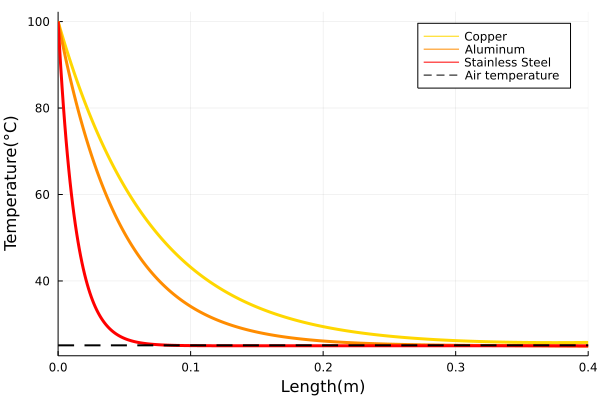

In [43]:
x_axis = [0: δx: N*δx]
dashline(y) = (Tₑₙᵥ - 273.15 + 1e-1) # dashed line for air temperature

C = "Copper"
A = "Aluminum"
S = "Stainless Steel"
T = "Air temperature"
xname = "Length(m)"
yname = "Temperature(°C)"

plot(x_axis, Copper_profile, xl=xname,yl=yname, c=:gold, lw=:3, xlim=(0, 0.4), label=C)
plot!(x_axis, Aluminum_profile, lw=:3, c=:darkorange, label=A)
plot!(x_axis, Steel_profile, lw=:3, c=:red, label=S)
plot!(x_axis, dashline, c=:black, line=(:dash, 2), label=T)

In [44]:
# calculating minimum kengths for temperature plateau
Copper_min = Min_length(Copper_theta)
Aluminum_min = Min_length(Aluminum_theta)
Steel_min = Min_length(Steel_theta)
println("Copper minimun length = ", Copper_min, " m")
println("Aluminum minimun length = ", Aluminum_min, " m")
println("Steel minimun length = ", Steel_min," m")

Copper minimun length = 0.315 m
Aluminum minimun length = 0.24 m
Steel minimun length = 0.084 m


In [45]:
# calculating total heat by definition and γ₀
kc = 398.
ka = 180.
ks = 14.

# Fourier's Law for x = 0: qf = -k.Aₛ(dT/dx); dT/dx = dθ/dx = γ₀ 
qf_copper = (-kc)*(pi*(D/2)^2)*γ₀_copper
qf_aluminum = (-ka)*(pi*(D/2)^2)*γ₀_aluminum
qf_steel = (-ks)*(pi*(D/2)^2)*γ₀_steel

println("Copper heat rate loss = ", round(qf_copper, digits=2), " W")
println("Aluminum heat rate loss = ", round(qf_aluminum, digits=2), " W")
println("Steel heat rate loss = ", round(qf_steel, digits=2)," W")

Copper heat rate loss = 8.31 W
Aluminum heat rate loss = 5.59 W
Steel heat rate loss = 1.56 W
